In [3]:
import numpy as np
import pandas as pd
import time
import torch.nn as nn
import torch as th
from numpy.random import choice

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Configuration

In [4]:
args = {

    # Dataset
    "data"            : '/content/gdrive/MyDrive/Kaggle_HM/Kaggle_HM/data/trans_2000.csv',

    "item_size"         : 104547,  # Fixed for HM  data set
    "pad"               : 0,

    "train_share"       : 0.8,  # training data share from whole data

    "rp_buffer_size"    : 16,  # replay buffer

    # Model
    "gru_layer"         : 1,
    "hidden_factor"     : 64,
    "state_len"         : 8,

    # Train
    "epoch"             : 15,
    "epoch_size"        : -1,
    "batch_size"        : 256,
    "lr"                : 0.01,

    # Log
    "log_loss_period"   : 20,
    "evaluate_period"   : 100,

    # Evaluate

    # Reward
    "r_click"           : 1.0,
    "r_buy"            : 1.0, # There is no buy in HM data set
}

DEVICE = 'cuda' if th.cuda.is_available() else 'cpu'


# Utility

In [5]:
def print_timing_msg(start_time, cur_cid, total_cid, cur_epoch, total_epoch):

    cur_time = time.perf_counter()
    elapse = (cur_time - start_time) / 60

    all_epoch_cid = total_cid * total_epoch
    finished_cid  = total_cid * cur_epoch + cur_cid

    left = (all_epoch_cid / finished_cid) * elapse

    print("Elapse %.2f mins, estimate %.2f mins left " % (elapse, left))



def get_train_msg(args, num_batches, total_step):
    msg = "==================================\n"  \
        + "Modle: Basic GRU on ReplayBuffer\n"  \
        + "GRU layer %d\n"      % (1) \
        + "Embedding size %d\n" % (args.hidden_factor) \
        + "Learn rate is %f\n"  % (args.lr) \
        + "Total epoch %d\n"    % (args.epoch) \
        + "Each epoch has %d batches, total %d batches\n" % (num_batches, total_step) \
        + "=================================="
    return msg

def get_data():

    df = pd.read_csv(args["data"])

    cus_id  = df['customer_id'].unique()
    item_id = df['article_id'].unique()

    code_to_item = {value: index for index, value in enumerate(item_id)}

    df['article_id'] = df['article_id'].apply(lambda x: code_to_item[x])

    train_cid = choice(cus_id, int(args["train_share"] * len(cus_id)), replace=False)

    data_train = df[df["customer_id"].isin(train_cid)]
    data_val = df[~df["customer_id"].isin(train_cid)]

    return data_train, data_val, item_id

def get_state_and_action(batch, device):
    rc_state  = th.tensor([x[0] for x in batch], dtype=th.int32).to(device)
    rc_action = th.tensor([x[1] for x in batch], dtype=th.int64).to(device)
    return rc_state, rc_action

class ReplayBuffer():

    def __init__(self, raw_data : pd.DataFrame, batch_size):

        self.raw_data = raw_data

        self.cid = raw_data['customer_id'].unique()
        self.groups = self.raw_data.groupby(['customer_id'])

        self.batch_size = batch_size
        self.buffer_size = args["rp_buffer_size"] * self.batch_size

        self.buffer = []
        self.reset()

    def __iter__(self):
        return self

    def reset(self):
        self.idx = 0
        self.buffer.clear()

    def progress(self):
        return self.idx

    def total(self):
        return len(self.cid)

    def pad_history(self, itemlist, length, pad_item):
        if len(itemlist) >= length:
            return itemlist[-length:]
        if len(itemlist) < length:
            temp = [pad_item] * (length - len(itemlist))
            itemlist.extend(temp)
            return itemlist

    def conver(self, cid):
        '''
        Conver data for a certain cid into
        :param cid:
        :return:
        '''
        records = []
        history = []

        for index, row in self.groups.get_group(cid).iterrows():
            s = list(history)
            s = self.pad_history(s, args["state_len"], args["pad"])
            action = row['article_id']
            history.append(row['article_id'])
            records.append((s, action, row['price'], row['sales_channel_id']))

        return records
    
    def refill(self):
        while self.idx < len(self.cid) and len(self.buffer) < self.buffer_size:
            self.buffer.extend(self.conver(self.cid[self.idx]))
            self.idx += 1

    def __next__(self):

        if len(self.buffer) < self.batch_size:
            self.refill()

        # if buffer size still smaller than a batch size after filling,
        # it means all data was
        if len(self.buffer) < self.batch_size:
            raise StopIteration
            
        ret = self.buffer[:self.batch_size]
        self.buffer = self.buffer[self.batch_size :]
            
        return ret



def evaluate(model, val_data):

    model.eval()
    val_data.reset()

    pred = np.array([], dtype=np.int32)
    ans = np.array([], dtype=np.int32)
    top12 = []

    for batch in val_data:

        states, actions = get_state_and_action(batch, device=DEVICE)

        logits = model(states).cpu().detach().numpy()

        predicts = np.argmax(logits, axis=1)

        pred  = np.concatenate((pred, predicts), axis=0)
        ans   = np.concatenate((ans,  actions.cpu().detach().numpy()), axis=0)
        top12.extend([x[-12:] for x in np.argpartition(logits, (-12, -1))])

    acc1  = sum(pred == ans) / len(ans)
    acc12 = sum([x in y for (x , y) in zip(ans, top12)]) / len(ans)

    print(f"\n Eval ===========> Accuracy @1: {acc1} ,  @12:  {acc12}")

    return acc1, acc12

# Model

In [6]:
class GRUnetwork(nn.Module):

    def __init__(self):
        super(GRUnetwork, self).__init__()

        embedding_size = args["hidden_factor"]

        self.embedding = nn.Embedding(args["item_size"],
                                      embedding_size,
                                      padding_idx = args["pad"],
                                      max_norm=True)

        self.gru = nn.GRU(embedding_size,
                          embedding_size,
                          batch_first = True,
                          num_layers = args["gru_layer"])

        self.fc = nn.Linear(embedding_size, args["item_size"])

    def forward(self, input):
        x = self.embedding(input)
        x, hidden = self.gru(x)  # (N,L,H_in)  => (batch size, sequence length, input size)
        output = self.fc(th.squeeze(hidden) )
        return output

    def initHidden(self):
         pass

    @staticmethod
    def create_model():

        model = GRUnetwork().to(DEVICE)

        loss_fn = nn.CrossEntropyLoss(reduction="mean")
        optimizer = th.optim.Adam(model.parameters(), lr=args['lr'])

        return model, loss_fn, optimizer


################################################
#  Train 
################################################

def train_model():

    print("Training ==============================")
    print(args)
    print("\n\n\n")

    # get training data
    data_train, data_val, item_id = get_data()

    rb_train = ReplayBuffer(data_train, args["batch_size"])
    rb_val   = ReplayBuffer(data_val, args["batch_size"])

    # get model, loss function and optimizer
    model, loss_fn, optimizer = GRUnetwork.create_model()

    his_loss, his_eval1, his_eval2 = [], [], []

    start_time = time.perf_counter()

    for i in range(args['epoch']):

        rb_train.reset()

        for idx, batch in enumerate(rb_train):

            model.train()
            model.zero_grad()

            states, actions = get_state_and_action(batch, device=DEVICE)

            logits = model(states)
            loss = loss_fn(logits, actions)

            loss.backward()
            optimizer.step()
                
        # Message logging
        #if idx % args['log_loss_period'] == 0 and idx != 0:
        print(f"Training: {rb_train.progress()}/{rb_train.total()} for  Epoch: {i}/{args['epoch']}: Loss : {loss}")
        print_timing_msg(start_time, rb_train.progress(), rb_train.total(), i, args['epoch']) 

        # Evaluate after each epoch
        his_loss.append(float(loss))
        eval = evaluate(model, rb_val)

        his_eval1.append(eval[0])
        his_eval2.append(eval[1])

    return model, his_loss, (his_eval1, his_eval2)

# Training Model

In [7]:
model, his_loss, his_eval = train_model()

Training ==============================
{'data': '/content/gdrive/MyDrive/Kaggle_HM/Kaggle_HM/data/trans_2000.csv', 'item_size': 104547, 'pad': 0, 'train_share': 0.8, 'rp_buffer_size': 16, 'gru_layer': 1, 'hidden_factor': 64, 'state_len': 8, 'epoch': 15, 'epoch_size': -1, 'batch_size': 256, 'lr': 0.01, 'log_loss_period': 20, 'evaluate_period': 100, 'r_click': 1.0, 'r_buy': 1.0}




Training: 1599/1599 for  Epoch: 0/15: Loss : 10.870427131652832
Elapse 0.08 mins, estimate 1.23 mins left 

 Eval ===========> Accuracy @1: 0.001608455882352941 ,  @12:  0.008042279411764705
Training: 1599/1599 for  Epoch: 1/15: Loss : 9.419352531433105
Elapse 0.39 mins, estimate 2.92 mins left 

 Eval ===========> Accuracy @1: 0.00034466911764705885 ,  @12:  0.0031020220588235292
Training: 1599/1599 for  Epoch: 2/15: Loss : 8.58813762664795
Elapse 0.63 mins, estimate 3.14 mins left 

 Eval ===========> Accuracy @1: 0.00034466911764705885 ,  @12:  0.0029871323529411763
Training: 1599/1599 for  Epoch: 3/15: L

# Evaluate 

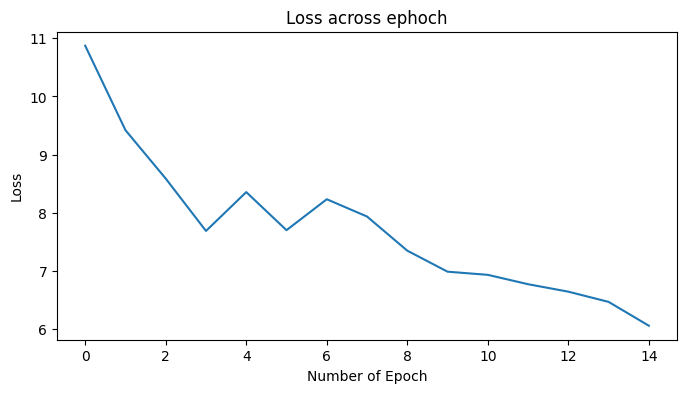

In [8]:
import matplotlib.pyplot as plt
plt.style.use('default')

def plot_loss(loss, title):
    ax = plt.figure(figsize=(8, 4))  
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Number of Epoch')
    plt.plot(np.arange(len(loss)), loss)
    plt.show()


plot_loss(his_loss, "Loss across ephoch")

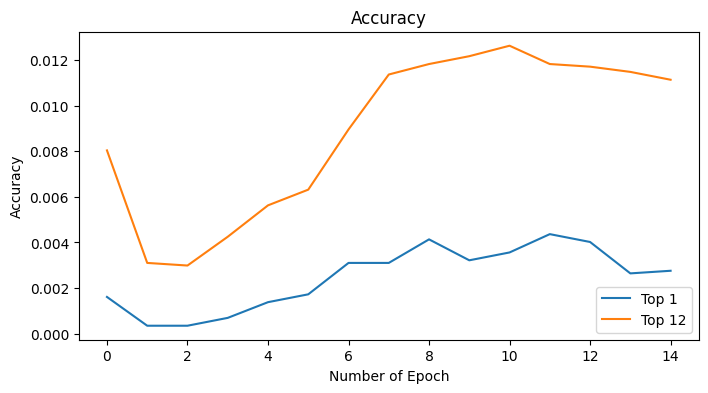

In [9]:
def plot_click_accuracy (top1, top12, title):
    ax = plt.figure(figsize=(8, 4))  
    plt.title(title)

    plt.ylabel('Accuracy')
    plt.xlabel('Number of Epoch')
    plt.plot(np.arange(len(top1)), top1, label="Top 1")
    plt.plot(np.arange(len(top12)), top12, label="Top 12")

    plt.legend(loc="lower right")
    plt.show() 

plot_click_accuracy(his_eval[0], his_eval[1], "Accuracy")